In [ ]:
# https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
 
import os
import tensorflow as tf
 
if not os.path.exists('/content/Flicker8k_Dataset'):
  image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                          extract = True)
  os.remove(image_zip)
 
if not os.path.exists('/content/Flickr8k_text'):
  os.makedirs('Flickr8k_text')
  annotation_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                          cache_subdir='/content/Flickr8k_text',
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                          extract = True)
  os.remove(annotation_zip)
 
image_path = '/content/Flicker8k_Dataset'
annotation_path = '/content/Flickr8k_text/Flickr8k.token.txt'

2351104/2340801 [==============================] - 0s 0us/step


In [ ]:
images = os.listdir(image_path)
print(f'Total images: {len(images)}')

#Preprocessing annotation from text file to dataframe
file = open(annotation_path,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

import pandas as pd
import numpy as np

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

In [ ]:
#Observe some image with annotation in dataset

number_of_pic = 2
image_dim = 224
target_size = (image_dim,image_dim,3)
count = 1

import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

fig = plt.figure(figsize=(20,20))
for jpgfnm in uni_filenames[10:10+number_of_pic]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(number_of_pic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(number_of_pic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print(f'Vocabulary Size: {len(set(vocabulary))}' )

#Cleaning unimportant words and punctuation
import string

def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print(f'Clean Vocabulary Size: {len(set(clean_vocabulary))}')

Vocabulary Size: 8918
Clean Vocabulary Size: 8357


In [ ]:
#Add <start> and <end> token to each annotation
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

Total captions data points: images 40455 and captions 40455


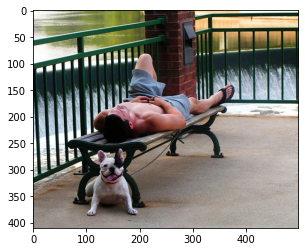

In [ ]:
#Path for all images
all_image_path = []
for image_name in data["filename"]:
   full_image_path = '/content/Flicker8k_Dataset/' + image_name
   all_image_path.append(full_image_path)
all_image_path[:10]

plt.imshow(load_img(all_image_path[15]))
print(f'Total captions data points: images {len(all_image_path)} and captions {len(all_captions)}')

<start>  man with beard and glasses wearing black sits on the grass <end>


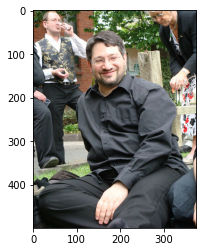

In [ ]:
#Limiting data points to 40000 for total batch 625 with 64 batch size

from sklearn.utils import shuffle
def data_limiter(num,total_captions,all_img_name_vector):
   train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
   train_captions = train_captions[:num]
   img_name_vector = img_name_vector[:num]
   return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_image_path)
import random
index = random.randint(0,4000)
print(train_captions[index])
plt.imshow(load_img(img_name_vector[index]))



In [ ]:
# We will use pretrained InceptionV3 for feature extraction
# We must preprocess all the images to the same size, i.e, 299×299 before feeding them into the model,
# and the shape of the output of this layer is 8x8x2048.

def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Map load_image with the model input
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
# We extract the features and store them in the respective .npy files 
# and then pass those features through the encoder.
# NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

from tqdm import tqdm

for img, path in tqdm(image_dataset): 
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save((path_of_feature), bf.numpy())

100%|██████████| 127/127 [01:54<00:00,  1.11it/s]


In [ ]:
# we tokenize the captions and build a vocabulary of all the unique words in the data. 
# We will also limit the vocabulary size to the top 5000 words to save memory. 
# We will replace words not in vocabulary with the token < unk >

top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]_^`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Create training and validation sets using an 80-20 split:
from sklearn.model_selection import train_test_split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
# Create a tf.data dataset to use for training our model.

BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#print(dataset)


In [ ]:
# Positional Encoding
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
# Transformer architecture
# Multihead attention

def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])



In [ ]:
# Encoder Layer

class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

In [ ]:
# Decoder Layer

class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

In [ ]:
# Encoder
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

In [ ]:
# Decoder
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights

In [ ]:
# Ensemble Transformer
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

In [ ]:
# Model Hyper paramerters
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)
   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size, max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
# Model Training

def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

import time
for epoch in range(30):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5140 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.1218 Accuracy 0.0186
Epoch 1 Batch 100 Loss 7.7147 Accuracy 0.0249
Epoch 1 Batch 150 Loss 7.4070 Accuracy 0.0279
Epoch 1 Batch 200 Loss 7.1119 Accuracy 0.0315
Epoch 1 Batch 250 Loss 6.8365 Accuracy 0.0353
Epoch 1 Batch 300 Loss 6.5912 Accuracy 0.0389
Epoch 1 Batch 350 Loss 6.3777 Accuracy 0.0425
Epoch 1 Batch 400 Loss 6.1868 Accuracy 0.0460
Epoch 1 Batch 450 Loss 6.0173 Accuracy 0.0492
Epoch 1 Loss 5.8729 Accuracy 0.0519
Time taken for 1 epoch: 133.344868183136 secs

Epoch 2 Batch 0 Loss 4.3630 Accuracy 0.0884
Epoch 2 Batch 50 Loss 4.3982 Accuracy 0.0812
Epoch 2 Batch 100 Loss 4.3441 Accuracy 0.0825
Epoch 2 Batch 150 Loss 4.2977 Accuracy 0.0832
Epoch 2 Batch 200 Loss 4.2469 Accuracy 0.0839
Epoch 2 Batch 250 Loss 4.2048 Accuracy 0.0848
Epoch 2 Batch 300 Loss 4.1582 Accuracy 0.0858
Epoch 2 Batch 350 Loss 4.1210 Accuracy 0.0867
Epoch 2 Batch 400 Loss 4.0835 Accuracy 0.0874
Epoch 2 Batch 450 Loss 4.0477 Accuracy 0.0883
Epo

In [ ]:
#Evaluation
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

['two', 'little', 'boys', 'playing', 'soccer']


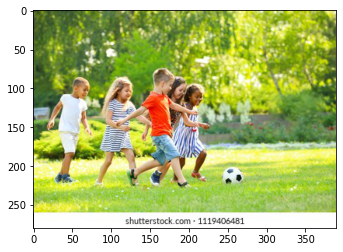

In [ ]:
import requests
url = 'https://image.shutterstock.com/image-photo/cute-little-children-playing-football-260nw-1119406481.jpg'
img_data = requests.get(url).content
with open('image_name.jpg', 'wb') as handler:
    handler.write(img_data)
plt.imshow(load_img('/content/image_name.jpg'))
caption,result,attention_weights = evaluate('/content/image_name.jpg')
for i in caption:
   if i=="<unk>":
      caption.remove(i)
print(caption)